In [33]:
import numpy as np
import csv
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
with open('mnist_train.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

data = data[1:]
data = [a[1:] for a in data]

In [14]:
xs = np.array(data).reshape((60000, 28, 28, 1)).astype(int)/255
ys = xs

print(xs.shape)
print(ys.shape)

(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [54]:
import pickle

with open('./xs','wb') as f: pickle.dump(xs, f)
with open('./ys','wb') as f: pickle.dump(ys, f)

In [72]:
l = tf.keras.layers

model = tf.keras.models.Sequential([
    l.Conv2D(filters=4, kernel_size=3, padding='valid', input_shape=(28, 28, 1)),
    l.Conv2D(filters=2, kernel_size=3, padding='valid'),
    l.Conv2D(filters=1, kernel_size=3, padding='valid'),
    l.Conv2D(filters=1, kernel_size=3, padding='valid'),

    l.Flatten(),

    l.Dense(100, activation='relu'),
    l.Dropout(0.3),


    l.Dense(2, activation='tanh'),


    l.Dense(100, activation='relu'),
    l.Dropout(0.3),

    l.Dense(20*20*4, activation='relu'),
    l.Reshape((20, 20, 4)),

    l.Conv2DTranspose(filters=4, kernel_size=3, padding='valid'),
    l.Conv2DTranspose(filters=2, kernel_size=3, padding='valid'),
    l.Conv2DTranspose(filters=1, kernel_size=3, padding='valid'),
    l.Conv2DTranspose(filters=1, kernel_size=3, padding='valid')
])

model.summary()

model.compile(optimizer='adam', loss='mse')

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_147 (Conv2D)          (None, 26, 26, 4)         40        
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 24, 24, 2)         74        
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 22, 22, 1)         19        
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 20, 20, 1)         10        
_________________________________________________________________
flatten_35 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 100)               40100     
_________________________________________________________________
dropout_57 (Dropout)         (None, 100)             

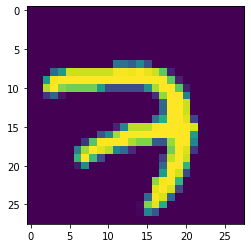

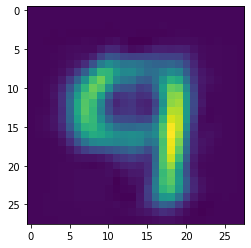

In [92]:
plt.imshow(xs[5000])
plt.show()

x = np.array([xs[5000]])
plt.imshow(model.predict(x)[0])
plt.show()

In [74]:
model.fit(xs, ys)

 409/1875 [=====>........................] - ETA: 1:27 - loss: 0.0596

KeyboardInterrupt: 

In [55]:
model.save('./model.h5')

In [76]:
model = tf.keras.models.load_model('./model.h5')